# Visualize ML Algorithms

In this notebook, we want to visualize the fitting process of gradient boosting.

In a first step, we will generate a toy data set. Then, we show the fitting process for each of above algos.

## Generate data

We first generate a couple of data points from the following complicated two-dimensional function:
$$
    y = f(x_1, x_2) = \frac{\sin(x_1^2 + x_2^2)}{x_1^2 + x_2^2} + \frac{\cos(x_1)-1}{2} ,
$$
$x_1, x_2 \in [-2\pi, 2\pi]$.

Besides the ground truth `theoretic`, we add Gaussian noise to mimic a real, `observed` data. To make things tricky, we drop a segment of the observed data.

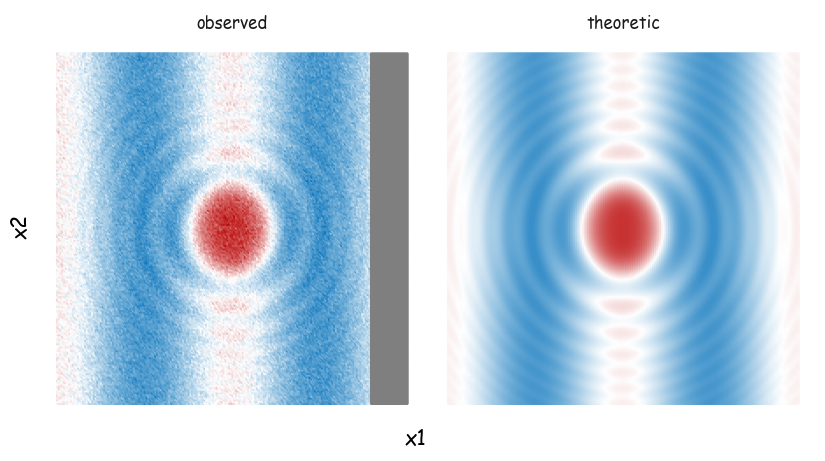

<ggplot: (-9223371881553095312)>

In [10]:
import numpy as np
import pandas as pd
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

# The theoretic function
def crazy_function(x1, x2):
    s = x1**2 + x2**2
    return np.sin(s)/s + (np.cos(x1) - 1)/2
    
def heatmap(df, ignore=None):
    """Heatmap of one or multiple responses by two "features" x1 and x2 in 
       pandas DataFrame df."""
    dat = df.copy()
    if ignore:
        dat = dat.drop(ignore, axis=1)
    
    dat = dat.melt(id_vars=['x1', 'x2'])
    
    p = (ggplot(aes(x='x1', y='x2', color='value'), data=dat) 
        + geom_point(shape='.', show_legend=False) 
        + scale_color_gradientn(colors=['#0471ba', 'white', '#ba0404'])
        + scale_x_continuous(limits=(-2*np.pi, 2*np.pi))
        + scale_y_continuous(limits=(-2*np.pi, 2*np.pi))
        + coord_fixed() 
        + facet_wrap("~variable")
        + theme_minimal(base_size=15, base_family="fantasy")
        + theme(panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                axis_text=element_blank()))
    return p

# Grid of values
t = np.linspace(-2*np.pi, 2*np.pi, num=200)

# Evaluate crazy_function on square grid and organize results as data set
df = pd.DataFrame([(x1, x2, crazy_function(x1, x2)) for x1 in t for x2 in t],
                  columns=['x1', 'x2', 'theoretic'])

# Add noise
np.random.seed(110)
df['observed'] = df['theoretic'] + np.random.normal(scale=0.1, size=df.shape[0])

# Remove right-most part
idx = df.x1 > 5
df.loc[idx, 'observed'] = np.nan

# Plot the observed and theoretic values
heatmap(df) + theme(figure_size=(10, 6))

In [11]:
df

,x1,x2,theoretic,observed
0,-6.283185,-6.283185,-0.005130,0.027730
1,-6.283185,-6.220038,0.004656,-0.074964
2,-6.283185,-6.156890,0.011817,0.152129
3,-6.283185,-6.093743,0.012230,-0.142549
4,-6.283185,-6.030595,0.005714,0.122387
...,...,...,...,...
39995,6.283185,6.030595,0.005714,NaN
39996,6.283185,6.093743,0.012230,NaN
39997,6.283185,6.156890,0.011817,NaN
39998,6.283185,6.220038,0.004656,NaN


## Prepare modeling

Now, we try to predict the function values $y$ as good as possible by the two "features" $x_1$ and $x_2$ with the help of the gradient boosting implementation [LightGBM](https://github.com/microsoft/LightGBM).

Besides visualizing the fitting process, we show how bad extrapolation works by setting aside a segment.

In [12]:
# Our two features
xvars = ['x1', 'x2']

import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Data split
train, test = train_test_split(df, test_size=0.2)

# Data interface of LightGBM
lgb_train = lgb.Dataset(train[xvars], label=train['observed'])

# Parameters (slightly optimized by 5-fold cross-validation)
params = {
    'objective': 'regression',
    'learning_rate': 1/3,
    'num_leaves': 63,
    'min_sum_hessian_in_leaf': 0.01
}

## Fit and evaluate

We are now ready to fit our model and evaluate it by studying heatmaps of

- the response $y$ (i.e. the ground truth),

- the predictions, as well as

- the residuals,

all calculated on the independent test data set. We go through this process several times, for increasing number of boosting rounds.

In [ ]:
for rounds in [2**i for i in range(11)]:
    # Fit model
    fitted = lgb.train(params, 
                       train_set=lgb_train, 
                       num_boost_round=rounds)

    # Calculate predictions and residuals
    pred = fitted.predict(df[xvars])
    df = df.assign(predictions=pred,
                   residuals=df.observed - pred)
    
    # Plot predictions, residuals, and response on test data
    p = (heatmap(df, ignore=["theoretic"]) 
         + labs(title=f"After boosting round {rounds}"))
    p.save(f"visualizing_ml/after_round_{rounds}.jpg", width=16, height=9)

## Wrap up

Sweet - the approximation error is extremely small.